<a href="https://colab.research.google.com/gist/KhawajaMuddassar/3baf5dc6c0b43cbbc752bfc0bd4c7538/sam-transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Segment Anything Model -SAM**

The Segment Anything Model (SAM) is a deep learning model developed by Meta (formerly Facebook) for image segmentation tasks. SAM is designed to enable users to efficiently segment objects within images, providing pixel-wise segmentation for any object with minimal input. It is a vision model that leverages a transformer-based architecture, allowing it to process images at a high level of abstraction. SAM employs a prompt-based approach, where users can provide various types of inputs, such as points, boxes, or text, to guide the segmentation process. The model's architecture is built around a vision transformer (ViT) backbone, which captures intricate image features, while the segmentation head outputs precise masks for objects of interest, making SAM highly flexible and capable of segmenting a wide range of objects in diverse contexts.

**Architecture:**
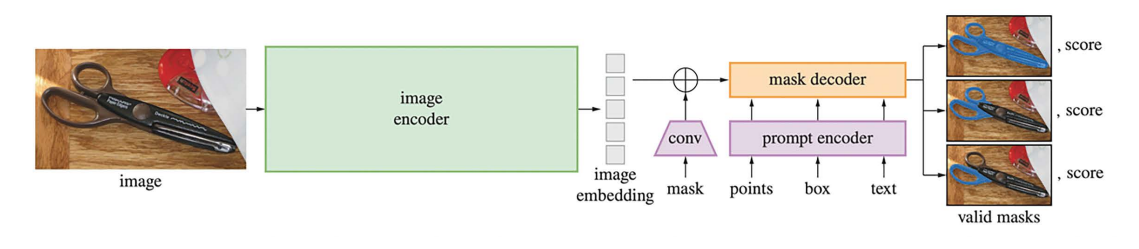


In the preceding image, the following steps are being performed:

1. An image is processed through an image encoder, which is a pre-trained vision transformer, to generate the corresponding image embeddings
2. Once the image embeddings are obtained, specific masks can be queried within the image by providing either dense masks (as shown in the figure above) or sparse masks, including points, boxes, and text
3. The prompt encoder processes inputs such as points, boxes, and masks, generating both dense and sparse embeddings. Point and box embeddings are constructed similarly to the embedding approach used in LayoutLM. Below, we explore the differences between the various types of masks:
    * **Dense masks** are ideal for scenarios where precise segmentation of complex objects is required, such as segmenting a person's hair or the leaves of a tree. In these cases, the user provides a rough contour of the desired mask, and SAM efficiently performs the task of extracting the detailed mask
    * **Sparse masks** are useful when we need to specify a text, bounding box, or point that corresponds to a specific region in the image, enabling targeted segmentation based on minimal user input
    * **If no mask, text, or point** input is provided, the model automatically generates 1,024 points uniformly distributed across the input image for the point encoder

    **Note:** In the case of a text prompt, it is processed through CLIP embeddings to obtain the corresponding text embedding when passed through the prompt encoder. For points and bounding boxes, they are represented by positional embeddings that correspond to the locations of the points or the boundaries of the boxes.
4. The embeddings are then fed into a mask decoder, which computes the attention between the prompt encoding and the image encoder, ultimately producing a set of segmentation masks

**Decoder Components**

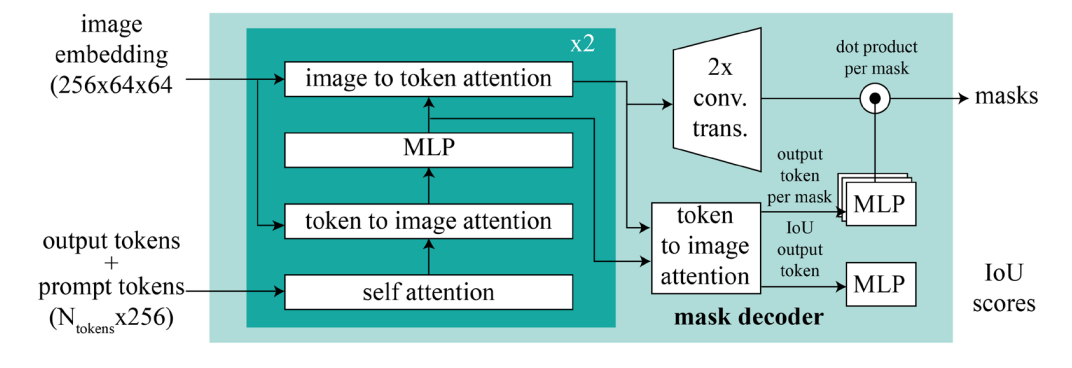

* **Image Embedding**: The process begins by generating an image embedding, which represents the input image as a set of feature vectors. These vectors are derived from the vision transformer, with each feature vector corresponding to a distinct image patch
* **Output Tokens + Prompt Tokens**: A prompt, such as a point, bounding box, or text, is represented as an embedding. Output tokens, akin to the CLS token in transformers, are learnable embeddings that encapsulate crucial information for effective segmentation. These tokens enable the generation of three potential masks corresponding to the given prompt
* **Attention Blocks**: These blocks function similarly to those in a transformer decoder, incorporating both self-attention (within the decoder output) and cross-attention between the encoder and decoder. This mechanism allows the model to effectively integrate and refine information from both the image and prompt embeddings for precise segmentation.
    * **Image to token attention:** This block helps the model to focus on specific features within the image embedding that are relevant to the tokens. It's a form of cross-attention
where image features inform the processing of the tokens.
    * **Token to image attention:** This does the reverse, allowing the tokens to influence the processing of the image features.
    * **Self-attention:** This mechanism allows the tokens to interact with each other, helping the model to integrate information across the different tokens
    * **Multilayer perceptron (MLP):** This is a neural network layer that processes the features from the attention mechanisms to transform and combine information further
    * **Iterations:** The attention blocks and MLPs are stacked in layers (as indicated by x2), allowing the model to refine its understanding of the image and prompt with each iteration.
    * **2x convolutional transpose:** This is an up-sampling operation that increases the spatial resolution of the feature maps. It's also known as deconvolution. This operation is used to go from a lower-resolution embedding back to the higher-resolution space of the original image, which is necessary for creating detailed masks
    * **Dot product per mask:** This step involves computing the dot product between the refined features and each potential mask. It's a way of scoring how well each feature corresponds to each mask, effectively aligning the feature vectors with the predicted masks
    * **Masks:** The result of the dot product per mask is used to generate the final segmentation masks. Each mask corresponds to a particular region or object in the image as defined by the prompt.
    * **Intersection over union (IoU) scores:** Alongside the mask generation, the model also outputs IoU scores. IoU measures the overlap between the predicted segmentation mask and the ground truth mask.


In [ ]:
# Install Packages and define utility functions
!pip install -q transformers
# Utility functions
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()
    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))
    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

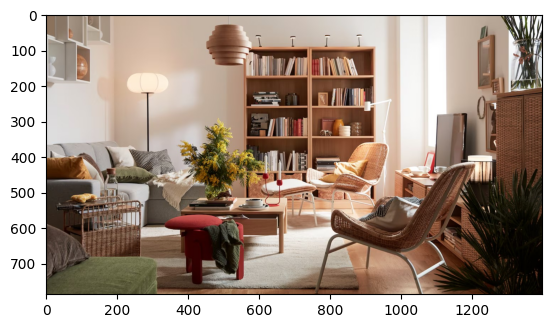

In [ ]:
# Model Loading
import torch
from transformers import SamModel, SamProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

# Load the example image
from PIL import Image
img_url = "/content/y137zsid.png"
raw_image = Image.open(img_url).convert("RGB")
plt.imshow(raw_image)

# Retrieve the image embeddings
#In order to avoid computing multiple times the same image embeddings,
# we will compute it only once, and use these embeddings to directly feed them to the model for faster inference
inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

# **2D points to predict a mask**

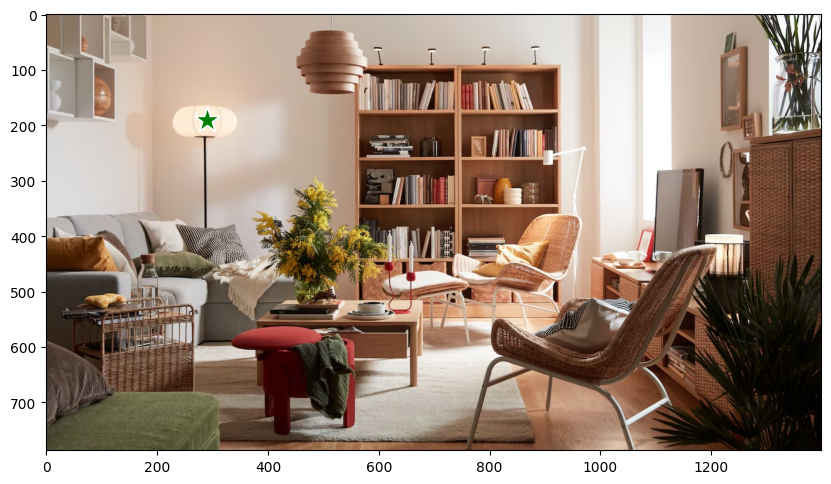

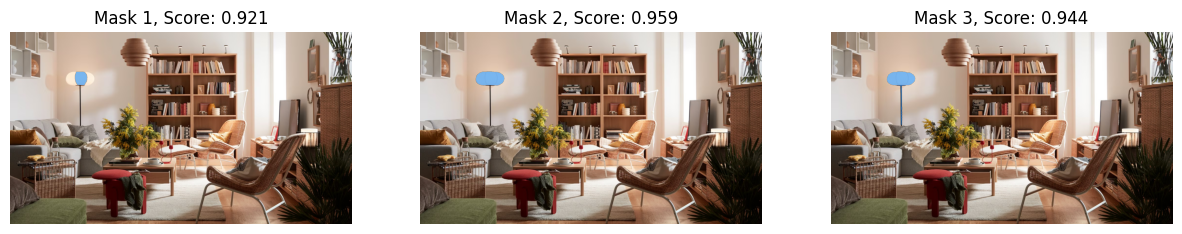

In [ ]:
input_points = [[[290, 190]]]
show_points_on_image(raw_image, input_points[0])

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores
show_masks_on_image(raw_image, masks[0], scores)

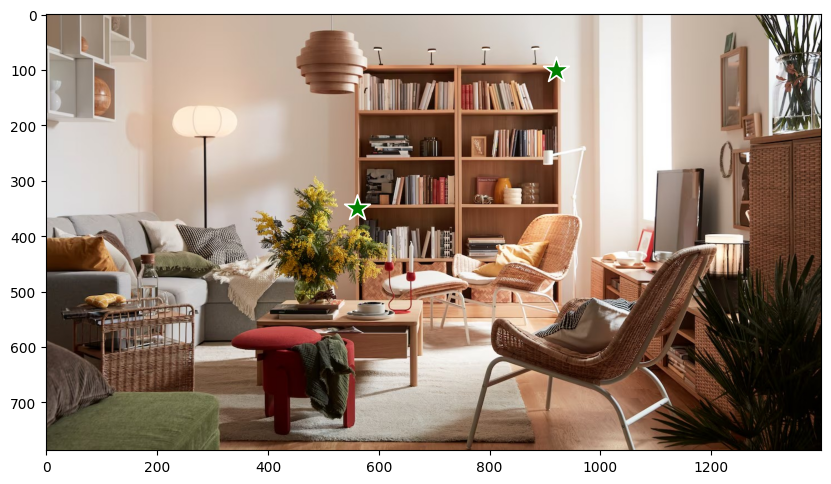

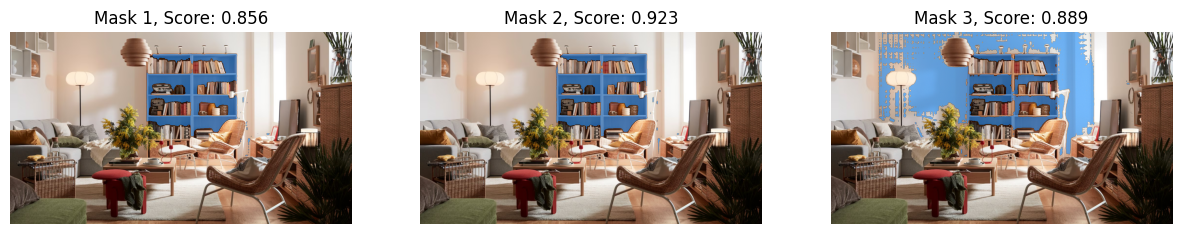

In [ ]:
# You can also feed a set of points to predict a single mask
input_points = [[[920, 100], [560, 350]]]
show_points_on_image(raw_image, input_points)
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores
show_masks_on_image(raw_image, masks[0], scores)